# Detect Negative Reviews (BERT)
(machine learning for texts)

### Content

1. [Introduction](#intro)
2. [General information](#general)
3. [Preparing Dataset](#prep)
4. [Models](#models)
5. [Training Best Model on Test Set](#test_set)
8. [Conclusion](#conclusion)

### Introduction<a href='intro'></a>
The goal is to train a model to automatically detect negative reviews.

*Libraries*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import transformers
from tqdm import notebook

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
state = 123456

In [3]:
try:
    toxic_comm_dataset = pd.read_csv("toxic_comments.csv")
except:
    toxic_comm_dataset = pd.read_csv("/datasets/toxic_comments.csv")

## General information<a href='general'></a>

In [4]:
toxic_comm_dataset.sample(10,random_state=state)

,text,toxic
96964,"""\n EDIT: also, I'll go to that page, but sinc...",0
4353,""" HJ Mitchell has no justification for claimin...",0
113108,"""\nThis isn't meant facetiously, but it might ...",0
157090,"If you can read, you know who and where. 190....",0
80185,"I have removed the Category:Lesbian, gay, bise...",0
27962,"""\n\n Why is my article bad? \n\nHi Gilo,\n\nW...",0
132813,Shoo! Complaining about something that I refac...,0
80398,You're invited to Wikipedia Takes St. Louis! \...,0
94878,"""\nWe should not change the F to lower case. T...",0
8617,I dont care about kurds actually (i am neutral...,1


In [5]:
toxic_comm_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
toxic_comm_dataset.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
toxic_comm_dataset.duplicated().sum()

0

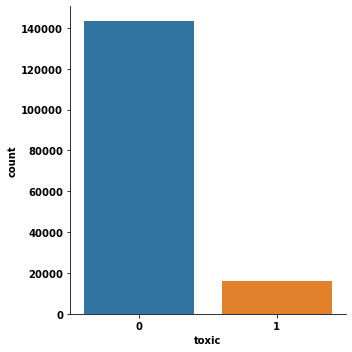

In [8]:
toxic_plot = sns.catplot(x='toxic', kind='count', data=toxic_comm_dataset, order=toxic_comm_dataset.toxic.value_counts().index)

### Conclusion

We have dataset with 159571 entries and to columns.<br>
No missing data.<br>
No duplicates.<br>
For column toxic we need to do downsapling.

## Preparing Dataset<a href='prep'></a>

*Tokenization*

In [9]:
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')

In [10]:
tokenized = toxic_comm_dataset['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


In [11]:
max_len = max(map(len, tokenized))
max_len

4950

In [12]:
len_tok = tokenized.apply(lambda x: len(x))
print('We need to delete',len_tok[len_tok>512].count())
index_to_drop = len_tok[len_tok>512].index

We need to delete 3523


In [13]:
toxic_comm_dataset= toxic_comm_dataset.drop(index_to_drop).reset_index(drop=True)
tokenized = tokenized.drop(index_to_drop).reset_index(drop=True)

In [14]:
tokenized

0         [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1         [101, 1040, 1005, 22091, 2860, 999, 2002, 3503...
2         [101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...
3         [101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...
4         [101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...
                                ...                        
156043    [101, 1000, 1024, 1024, 1024, 1024, 1024, 1998...
156044    [101, 2017, 2323, 2022, 14984, 1997, 4426, 200...
156045    [101, 13183, 6290, 26114, 1010, 2045, 2015, 20...
156046    [101, 1998, 2009, 3504, 2066, 2009, 2001, 2941...
156047    [101, 1000, 1998, 1012, 1012, 1012, 1045, 2428...
Name: text, Length: 156048, dtype: object

*Target*

In [15]:
target = toxic_comm_dataset['toxic']

*Down Sampling*

In [16]:
def down_sampling(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=state)] + [features_ones]
        )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=state)] + [target_ones]
        )
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=state)

    return features_downsampled.reset_index(drop=True), target_downsampled.reset_index(drop=True)

In [17]:
tokenized_downsampled, target_downsapled = down_sampling(tokenized, target, 0.15)

In [18]:
max_len = max(map(len, tokenized_downsampled))
max_len

512

*Adding zeros*

In [19]:
def add_zeros(zeros):
    zeros = np.array(zeros + [0]*(max_len - len(zeros)))
    return zeros


- Adding zeros to arrays with smaller len.

*Padding and Masks*

In [20]:
tokenized_downsampled = tokenized_downsampled.apply(add_zeros).to_numpy()

padded = np.zeros((len(tokenized_downsampled), len(tokenized_downsampled[0])))

for i in range(len(tokenized_downsampled)):
    padded[i,:] = tokenized_downsampled[i]

In [21]:
attention_mask = np.where(padded != 0, 1, 0)

In [22]:
padded.shape

(36904, 512)

In [23]:
attention_mask.shape

(36904, 512)

*BERT(using CUDA to run code)*

In [24]:
model = transformers.BertModel.from_pretrained('bert-base-uncased')
model.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
model = model.to(device)

- Using GPU to run code

In [27]:
'''Takes a lot of time(without CUDA)'''
# batch_size = 20
# embeddings = []
#
# for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#     batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
#     attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
#
#     with torch.no_grad():
#         batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#
#     embeddings.append(batch_embeddings[0][:,0,:].numpy())

'Takes a lot of time(without CUDA)'

*Embedding*

In [28]:
'''Takes around 2h(with CUDA)'''
batch_size = 20
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // (batch_size))):
        batch = torch.cuda.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.cuda.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/1845 [00:00<?, ?it/s]

*Features*

In [29]:
features = np.concatenate(embeddings)

In [30]:
features.shape

(36900, 768)

In [31]:
target_downsapled.shape

(36904,)

In [32]:
index = list(range(0, features.shape[0]))

In [33]:
target_downsampled = target_downsapled[index]

In [34]:
target_downsampled.shape

(36900,)

*Split Data*

In [35]:
features_train, features_test, target_train, target_test = train_test_split(features, target_downsampled, test_size=0.3, random_state=state)

### Conclusion
We did:

Tokenization.<br>
Cut text more than 512 characters.<br>
Made downsaplimg.<br>
Padding and Masks.<br>
Embedding
Split data

## Models<a href='models'></a>

*Cross Validation*

In [36]:
def cr_val_sc(model, features, target):
    score = cross_val_score(model, features, target, cv=5, scoring = 'f1')
    final_score = score.mean()
    return print('f1 is: ',final_score)

*Models*

In [37]:
model_logistic = LogisticRegression(solver='sag')
model_forest = RandomForestClassifier(random_state=state, n_jobs=-1)
model_tree =  DecisionTreeClassifier(random_state=state)

*Linear Regression*

In [38]:
cr_val_sc(model_logistic, features_train, target_train)

C:\Users\Galina Rusinova\miniconda3\envs\12_ml_for_texts\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Galina Rusinova\miniconda3\envs\12_ml_for_texts\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Galina Rusinova\miniconda3\envs\12_ml_for_texts\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Galina Rusinova\miniconda3\envs\12_ml_for_texts\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


f1 is:  0.8754422728495781


C:\Users\Galina Rusinova\miniconda3\envs\12_ml_for_texts\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


*Parameters*

In [39]:
params_forest = {
    'n_estimators': list(range(50,300,50)),
    'max_depth':[5,15],
    'max_features' : list(range(1,20, 2))
}

In [40]:
params_tree = {
    'max_depth':list(range(1,20))
}

*Search for better parameters and f1 score*

In [41]:
CV_tree = GridSearchCV(model_tree,
                       param_grid=params_tree,
                       scoring = 'f1',
                       cv=5)

CV_tree.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123456),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19]},
             scoring='f1')

In [42]:
print('The best f1_score:', CV_tree.best_score_)
print('With parameters', CV_tree.best_params_)

The best f1_score: 0.749796238357133
With parameters {'max_depth': 8}


In [43]:
CV_forest = GridSearchCV(model_forest,
                         param_grid=params_forest,
                         scoring='f1',
                         cv=5)

CV_forest.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=123456),
             param_grid={'max_depth': [5, 15],
                         'max_features': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [50, 100, 150, 200, 250]},
             scoring='f1')

In [44]:
print('The best f1_score:', CV_forest.best_score_)
print('With parameters', CV_forest.best_params_)

The best f1_score: 0.8282004239334325
With parameters {'max_depth': 15, 'max_features': 15, 'n_estimators': 250}


### Conclusion

|Model| F1|
|---|---|
|LR|0.875|
|RFC|0.829|
|DTC|0.750|

The best model is Linear Regression.

## Training Best Model on Test Set<a href='test_set'></a>

In [45]:
model_best = LogisticRegression()

In [46]:
model_best.fit(features_train, target_train)

C:\Users\Galina Rusinova\miniconda3\envs\12_ml_for_texts\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [47]:
prediction_train = model_best.predict(features_train)
print('f1_score for Train Set: ', f1_score(target_train, prediction_train))

f1_score for Train Set:  0.890666422890575


In [48]:
prediction_test = model_best.predict(features_test)
print('f1_score for Train Set: ', f1_score(target_test, prediction_test))

f1_score for Train Set:  0.8719512195121951


## Conclusion<a href='conclusion'></a>

|Set| F1|
|---|---|
|Train|0.890|
|Test|0.872|

There is no difference in f1 score.
